# Bài toán dự đoán lượt xem youtube

# Bước 1: Tải tập dữ liệu lên Spark

#### Khởi tạo Spark

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Tạo phiên bản SparkSession
spark = SparkSession.builder \
    .appName("YouTubeTrending") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

# Kiểm tra web tại: http://localhost:4040
print(spark)


#### Tải tập dữ liệu lên Spark


In [2]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# Định nghĩa schema cho Spark DataFrame
schema = StructType([
    StructField("title", StringType(), True),
    StructField("channel_name", StringType(), True),
    StructField("daily_rank", IntegerType(), True),
    StructField("daily_movement", IntegerType(), True),
    StructField("weekly_movement", IntegerType(), True),
    StructField("snapshot_date", StringType(), True),
    StructField("country", StringType(), True),
    StructField("view_count", IntegerType(), True),
    StructField("like_count", IntegerType(), True),
    StructField("comment_count", IntegerType(), True),
    StructField("description", StringType(), True),
    StructField("thumbnail_url", StringType(), True),
    StructField("video_id", StringType(), True),
    StructField("channel_id", StringType(), True),
    StructField("video_tags", StringType(), True),
    StructField("kind", StringType(), True),
    StructField("publish_date", StringType(), True),
    StructField("language", StringType(), True)
])

df_spark = spark.read \
    .format("csv") \
    .option("header", "true") \
    .option("sep", ",") \
    .option("encoding", "ISO-8859-1") \
    .option("quote", '"') \
    .option("escape", '"') \
    .option("multiline", "true") \
    .schema(schema) \
    .load("trending_yt_videos_113_countries.csv")

df_spark.printSchema()


root
 |-- title: string (nullable = true)
 |-- channel_name: string (nullable = true)
 |-- daily_rank: integer (nullable = true)
 |-- daily_movement: integer (nullable = true)
 |-- weekly_movement: integer (nullable = true)
 |-- snapshot_date: string (nullable = true)
 |-- country: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- like_count: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- description: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- channel_id: string (nullable = true)
 |-- video_tags: string (nullable = true)
 |-- kind: string (nullable = true)
 |-- publish_date: string (nullable = true)
 |-- language: string (nullable = true)



In [3]:
num_rows = df_spark.count()  # Số hàng
num_cols = len(df_spark.columns)  # Số cột

print(f"DataFrame có {num_rows} hàng và {num_cols} cột.")

DataFrame có 2839146 hàng và 18 cột.


In [4]:
df_spark.show(5)

+--------------------+------------+----------+--------------+---------------+-------------+-------+----------+----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+-------------+--------------------+--------+
|               title|channel_name|daily_rank|daily_movement|weekly_movement|snapshot_date|country|view_count|like_count|comment_count|         description|       thumbnail_url|   video_id|          channel_id|          video_tags|         kind|        publish_date|language|
+--------------------+------------+----------+--------------+---------------+-------------+-------+----------+----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+-------------+--------------------+--------+
|Jah Prayzah - Man...| Jah Prayzah|         1|             0|              0|   2025-03-13|     ZW|   1710212|     42786|         8636|Our first single ...|https://i.ytimg.

# Bước 2: Tiền xử lý dữ liệu

In [5]:
from pyspark.sql.functions import col, to_date

df_spark = df_spark.withColumn("snapshot_date", to_date(col("snapshot_date"), "yyyy-MM-dd"))

In [6]:
from pyspark.sql.functions import regexp_replace, to_timestamp

df_spark = df_spark.withColumn("publish_date", regexp_replace(col("publish_date"), r"\+\d{2}:\d{2}", ""))
df_spark = df_spark.withColumn("publish_date", to_timestamp(col("publish_date"), "yyyy-MM-dd HH:mm:ss"))

In [7]:
from pyspark.sql.functions import  year, month, dayofmonth

df_spark = df_spark.withColumn("snapshot_year", year("snapshot_date"))
df_spark = df_spark.withColumn("snapshot_month", month("snapshot_date"))
df_spark = df_spark.withColumn("snapshot_weekday", dayofweek("snapshot_date"))
df_spark = df_spark.drop("snapshot_date")

df_spark = df_spark.withColumn("publish_year", year(df_spark["publish_date"]))
df_spark = df_spark.withColumn("publish_month", month(df_spark["publish_date"]))
df_spark = df_spark.withColumn("publish_day", dayofmonth(df_spark["publish_date"]))
df_spark = df_spark.drop("publish_date")

In [ ]:
df_spark.printSchema()

#### Kiểm tra giá trị thiếu

In [8]:
from pyspark.sql.functions import col, sum

df_spark.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_spark.columns]).show()

+-----+------------+----------+--------------+---------------+-------+----------+----------+-------------+-----------+-------------+--------+----------+----------+----+--------+-------------+--------------+----------------+------------+-------------+-----------+
|title|channel_name|daily_rank|daily_movement|weekly_movement|country|view_count|like_count|comment_count|description|thumbnail_url|video_id|channel_id|video_tags|kind|language|snapshot_year|snapshot_month|snapshot_weekday|publish_year|publish_month|publish_day|
+-----+------------+----------+--------------+---------------+-------+----------+----------+-------------+-----------+-------------+--------+----------+----------+----+--------+-------------+--------------+----------------+------------+-------------+-----------+
|    0|           0|         0|             0|              0|      0|         0|         0|            0|     527022|            0|       0|         0|    943188|   0|  717437|            0|             0|     

#### Xử lý các dữ liệu thiếu

In [9]:
df_spark = df_spark.dropna()
# Kiểm tra lại xem còn dữ liệu thiếu không
df_spark.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_spark.columns]).show()

+-----+------------+----------+--------------+---------------+-------+----------+----------+-------------+-----------+-------------+--------+----------+----------+----+--------+-------------+--------------+----------------+------------+-------------+-----------+
|title|channel_name|daily_rank|daily_movement|weekly_movement|country|view_count|like_count|comment_count|description|thumbnail_url|video_id|channel_id|video_tags|kind|language|snapshot_year|snapshot_month|snapshot_weekday|publish_year|publish_month|publish_day|
+-----+------------+----------+--------------+---------------+-------+----------+----------+-------------+-----------+-------------+--------+----------+----------+----+--------+-------------+--------------+----------------+------------+-------------+-----------+
|    0|           0|         0|             0|              0|      0|         0|         0|            0|          0|            0|       0|         0|         0|   0|       0|            0|             0|     

#### Kiểm tra dữ liệu trùng lặp

In [10]:
print("Tổng số dòng:", df_spark.count())
print("Số dòng không trùng lặp:", df_spark.dropDuplicates().count())
print("Số dòng trùng lặp:", df_spark.count() - df_spark.dropDuplicates().count())

Tổng số dòng: 1463094
Số dòng không trùng lặp: 1463094
Số dòng trùng lặp: 0


## Trực quan hóa dữ liệu

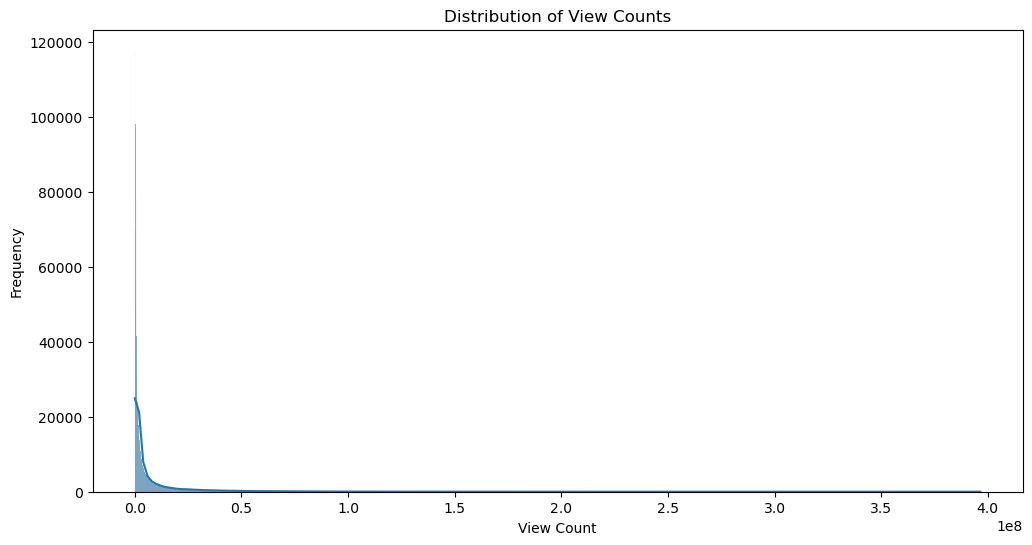

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


df_pandas = df_spark.select("view_count").toPandas()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.histplot(df_pandas['view_count'], kde=True)
plt.title('Distribution of View Counts')
plt.xlabel('View Count')
plt.ylabel('Frequency')
plt.show()


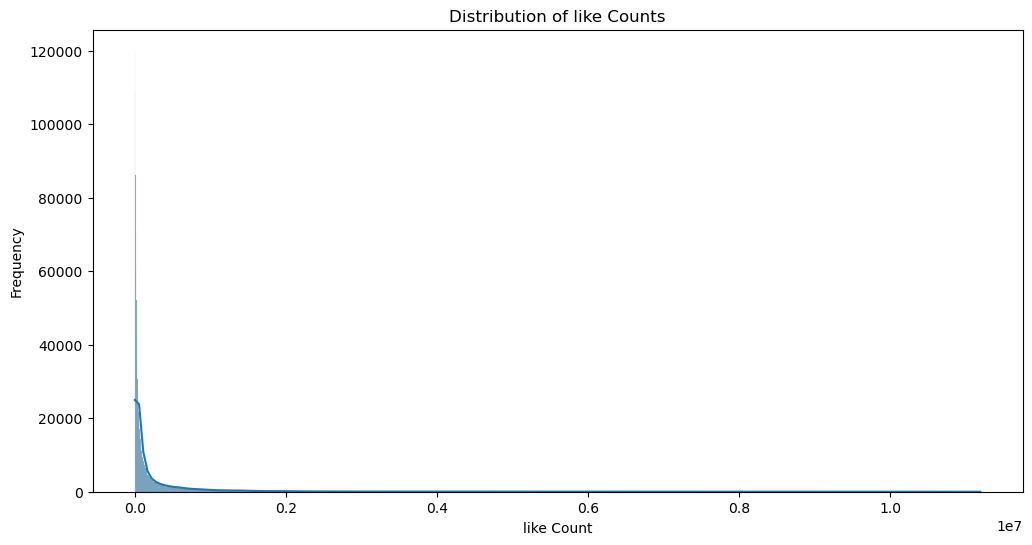

In [12]:

df_pandas = df_spark.select("like_count").toPandas()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.histplot(df_pandas['like_count'], kde=True)
plt.title('Distribution of like Counts')
plt.xlabel('like Count')
plt.ylabel('Frequency')
plt.show()

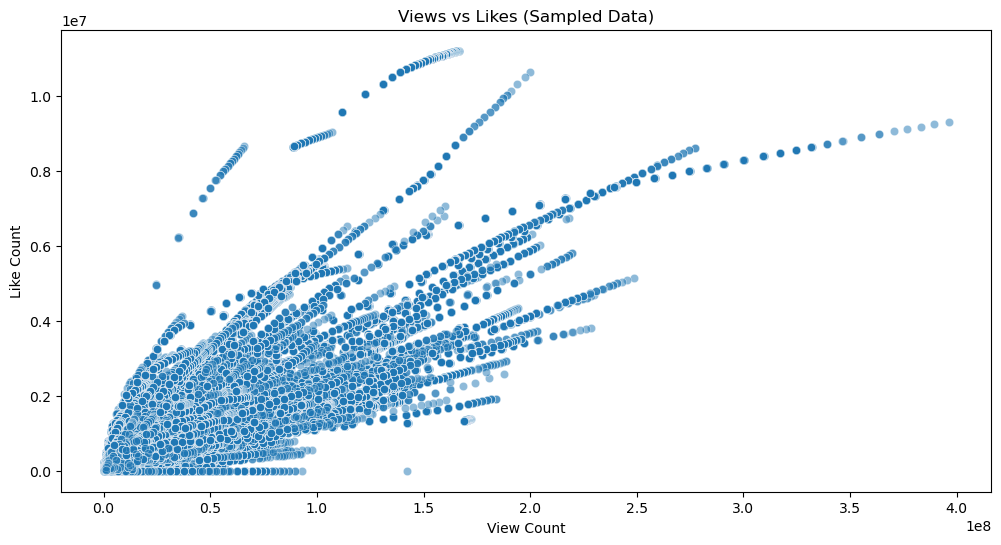

In [13]:
df_sample = df_spark.select("view_count", "like_count").toPandas()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_sample, x="view_count", y="like_count", alpha=0.5)
plt.xlabel("View Count")
plt.ylabel("Like Count")
plt.title("Views vs Likes (Sampled Data)")
plt.show()

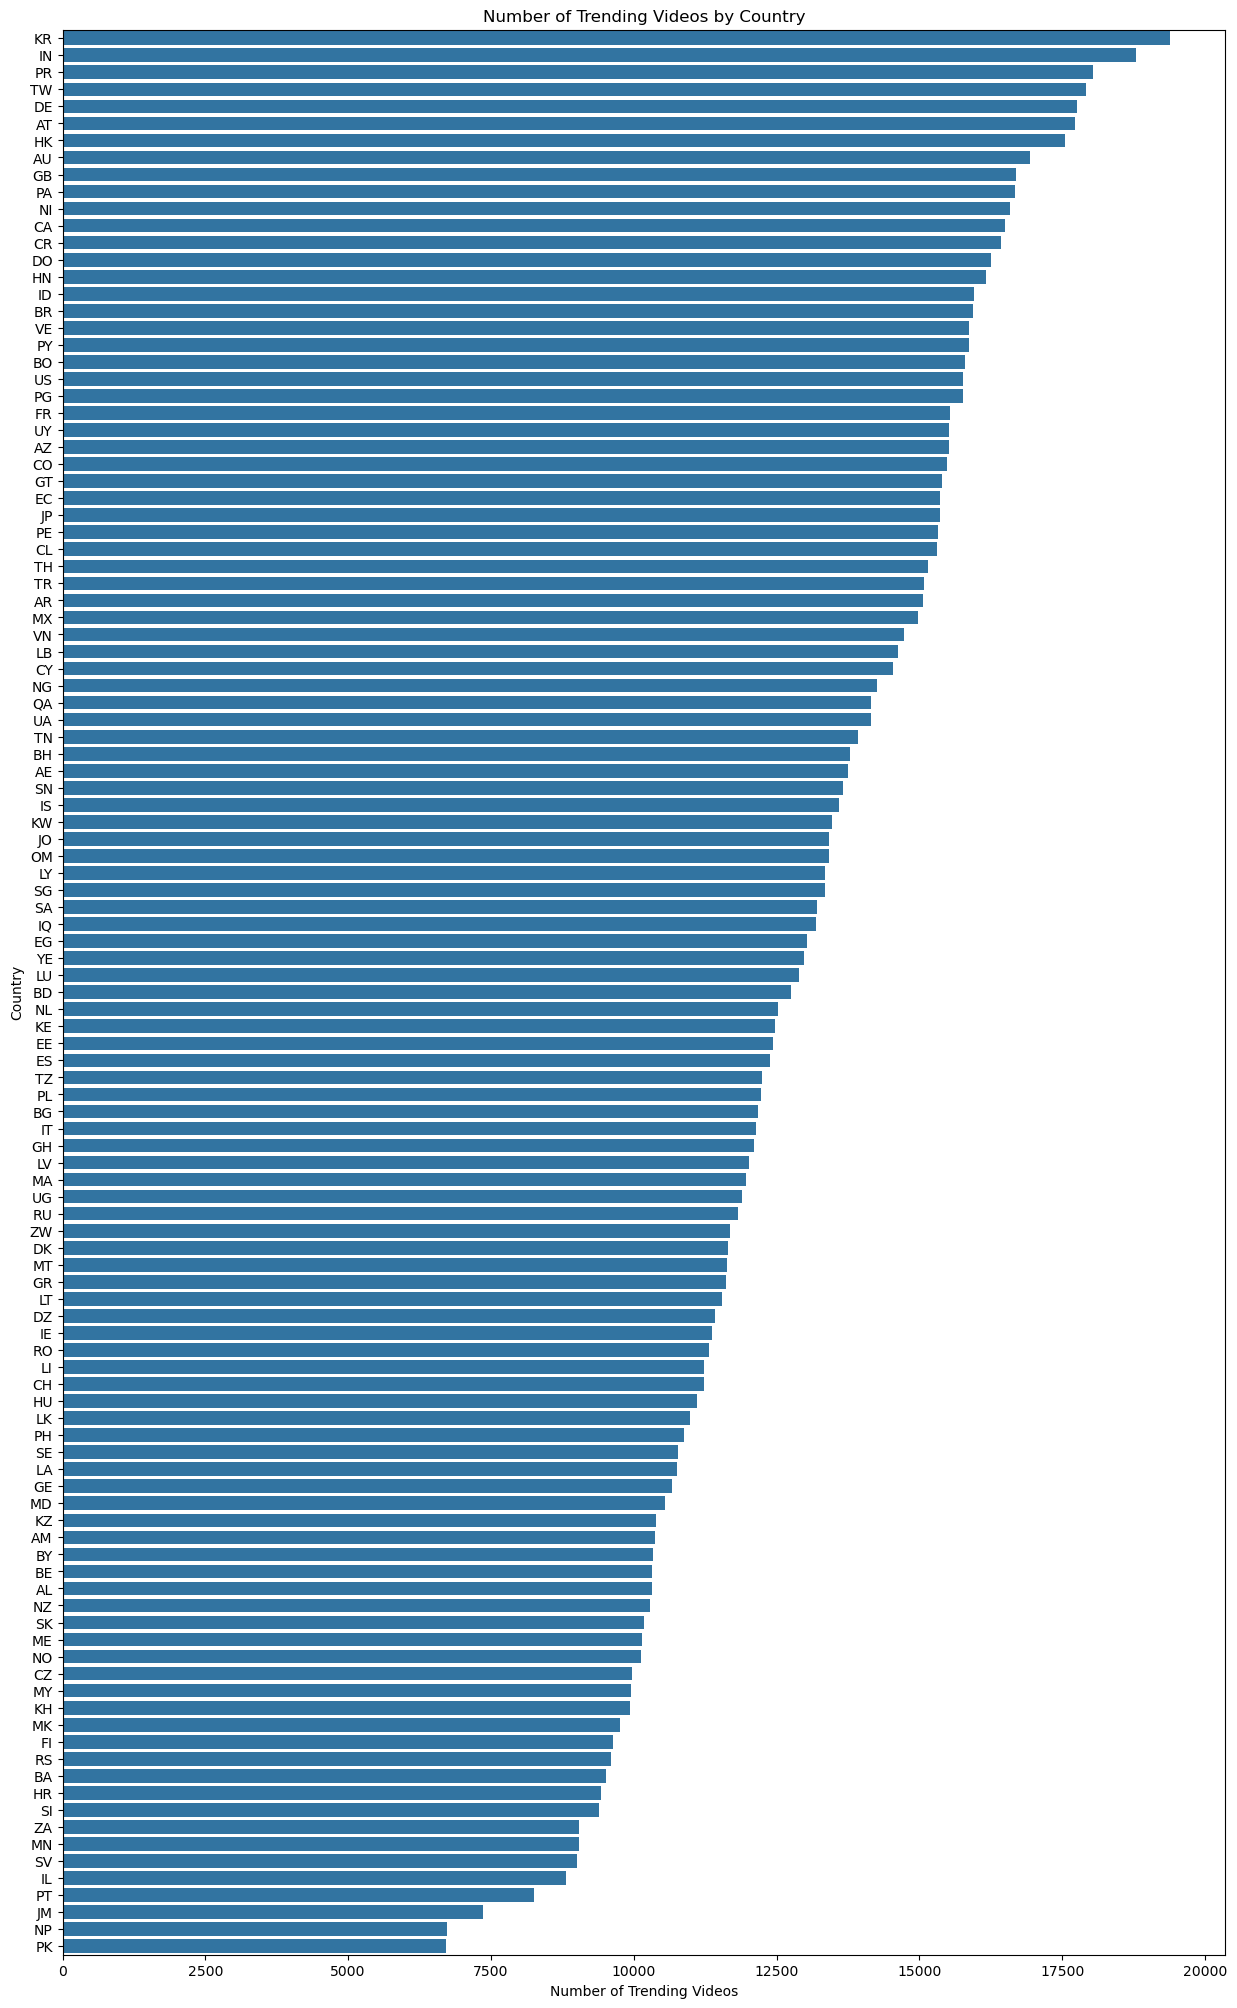

In [14]:
df = df_spark.select("country").toPandas()

# Đếm số lượng video theo quốc gia
country_counts = df["country"].value_counts()

# Vẽ biểu đồ
plt.figure(figsize=(15, 25))
sns.barplot(x=country_counts.values, y=country_counts.index)  
plt.xlabel("Number of Trending Videos")
plt.ylabel("Country")
plt.title("Number of Trending Videos by Country")
plt.show()

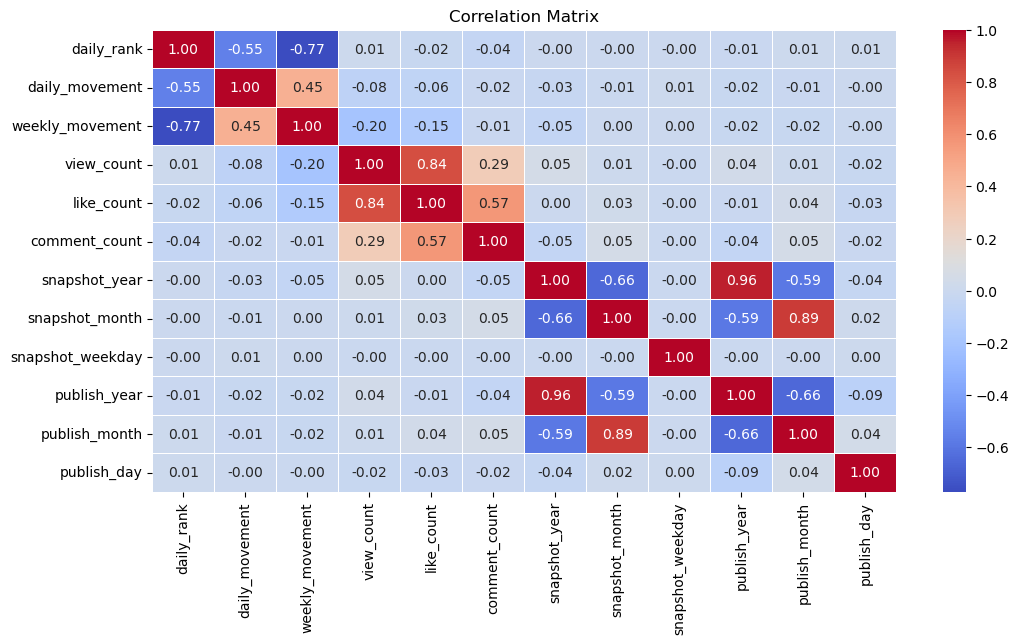

In [15]:
# Lọc các cột số trong PySpark
numeric_cols = [field.name for field in df_spark.schema.fields if field.dataType.simpleString() in ["int", "double", "float", "bigint"]]

# Chuyển DataFrame PySpark sang Pandas (chỉ các cột số)
pdf = df_spark.select([col(c) for c in numeric_cols]).toPandas()

# Tính ma trận tương quan
corr_matrix = pdf.corr()

# Vẽ heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Bước 3: Chia tập dữ liệu thành tập huấn luyện và tập kiểm thử


## Chuyển đổi các kiểu dữ liệu string

In [16]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

# Danh sách các cột dạng string cần mã hóa
categorical_cols = ["channel_name", "country", "channel_id", "video_tags", "kind", "language"]

# Tạo các StringIndexer cho từng cột
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in categorical_cols]

# Tạo pipeline để thực hiện mã hóa
pipeline = Pipeline(stages=indexers)

# Áp dụng pipeline vào dữ liệu
df_spark = pipeline.fit(df_spark).transform(df_spark)

# Xóa các cột ban đầu
df_spark = df_spark.drop(*categorical_cols)

In [17]:
df_spark.printSchema()

root
 |-- title: string (nullable = true)
 |-- daily_rank: integer (nullable = true)
 |-- daily_movement: integer (nullable = true)
 |-- weekly_movement: integer (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- like_count: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- description: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- snapshot_year: integer (nullable = true)
 |-- snapshot_month: integer (nullable = true)
 |-- snapshot_weekday: integer (nullable = true)
 |-- publish_year: integer (nullable = true)
 |-- publish_month: integer (nullable = true)
 |-- publish_day: integer (nullable = true)
 |-- channel_name_index: double (nullable = false)
 |-- country_index: double (nullable = false)
 |-- channel_id_index: double (nullable = false)
 |-- video_tags_index: double (nullable = false)
 |-- kind_index: double (nullable = false)
 |-- language_index: double (nullable = false

In [19]:
quantiles = df_spark.approxQuantile("view_count", [0.33, 0.66, 0.9], 0.01)
print("33% quantile:", quantiles[0])
print("66% quantile:", quantiles[1])
print("90% quantile:", quantiles[2])

33% quantile: 630825.0
66% quantile: 3787672.0
90% quantile: 24137951.0


#### Chia tập dữ liệu

In [38]:
from pyspark.sql.functions import when, col

df_spark = df_spark.withColumn("view_category",
    when(col("view_count") < 630825, "low")
    .when((col("view_count") >= 630825) & (col("view_count") < 3787672), "medium")
    .otherwise("high")
)

# Định nghĩa tỷ lệ lấy mẫu cho mỗi nhóm
fractions = {"low": 0.8, "medium": 0.8, "high": 0.8}

# Lấy tập train với tỷ lệ mong muốn
train_data = df_spark.sampleBy("view_category", fractions, seed=42)

# Lấy phần còn lại làm tập test
test_data = df_spark.subtract(train_data)

train_counts = train_data.groupBy("view_category").count()
test_counts = test_data.groupBy("view_category").count()

train_counts.show()
test_counts.show()

+-------------+------+
|view_category| count|
+-------------+------+
|          low|375935|
|         high|394622|
|       medium|400123|
+-------------+------+

+-------------+------+
|view_category| count|
+-------------+------+
|          low| 93879|
|         high| 98067|
|       medium|100468|
+-------------+------+



# Bước 4: Khởi tạo và huấn luyện mô hình

#### Khởi tạo mô hình

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Chọn các cột đặc trưng (bỏ cột target 'view_count' và các cột không cần thiết)
feature_cols = ['daily_rank', 'daily_movement', 'weekly_movement', 'like_count', 'comment_count']

# Biến đổi thành dạng vector để đưa vào mô hình
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(train_data).select("features", "view_count")
test_data = assembler.transform(test_data).select("features", "view_count")

#### Huấn luyện mô hình

In [36]:
model = rf.fit(train_data)


#### Kiểm tra mô hình

In [24]:
predictions = model.transform(test_data)
predictions.select("view_count", "prediction").show(10)


+----------+--------------------+
|view_count|          prediction|
+----------+--------------------+
|  15575840|2.6269147034634635E7|
|   1571270|   681000.7391724949|
|   4238947|    3562611.73345731|
|  31017895|2.8053415419043597E7|
|    474759|  1872537.0248722841|
|    135709|  1018047.8809905924|
|   3217353|   6705572.680804346|
|    484835|  1136153.2946129406|
|    984620|   2471513.431158241|
|     69479|  439668.03128664254|
+----------+--------------------+
only showing top 10 rows



# Bước 5: Đánh giá mô hình

In [25]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="view_count", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"RMSE: {rmse}")



RMSE: 9469290.16698357


In [26]:
from pyspark.sql.functions import mean

# Cách 1: Dùng mean()
df_spark.select(mean("view_count")).show()

+-----------------+
|  avg(view_count)|
+-----------------+
|9188706.707166458|
+-----------------+



# Đóng kết nối

In [ ]:
# Đóng kết nối Spark
spark.stop()
